# Datenvorbereitung für Data Mining Cup 2014
## Burk, Dau, Donner, Welsch, Wesemann
### Algorithmen: SVM und KNN

In [1]:
# import der bibliotheken

import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# einlesen der zu bereinigenden Daten
df = pd.read_csv('data/orders_train.txt', delimiter=';')

# anzeigen der ersten 5 zeilen des datensatzes
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,?,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0


**kommentar:**
wir sehen in zeile 4 (row_id = 3) einen fehlenden wert, also einen "missing value", welcher durch ein fragezeichen gekennzeichnet ist

In [3]:
# um zu prüfen, ob die missing values richtig gezählt werden, können wir die funktion df.info nutzen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481092 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   orderItemID     481092 non-null  int64  
 1   orderDate       481092 non-null  object 
 2   deliveryDate    481092 non-null  object 
 3   itemID          481092 non-null  int64  
 4   size            481092 non-null  object 
 5   color           481092 non-null  object 
 6   manufacturerID  481092 non-null  int64  
 7   price           481092 non-null  float64
 8   customerID      481092 non-null  int64  
 9   salutation      481092 non-null  object 
 10  dateOfBirth     481092 non-null  object 
 11  state           481092 non-null  object 
 12  creationDate    481092 non-null  object 
 13  returnShipment  481092 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 51.4+ MB


**kommentar:**
- uns fällt auf, dass zum einen alle spalten als "vollständig" markiert sind (non-null count = anzahl der gesamten zeilen) und zudem die datentypen für alle datumsspalten "falsch" sind.

**to-do:**
- anpassen der null-values
- anpassen der datentypen für datumsfelder

In [4]:
# als weitere funktion, um den datensatz zu beschreiben (also uns "mathematische größen" anzeigen zu lassen), probieren wir df.describe() aus
df.describe()

,orderItemID,itemID,manufacturerID,price,customerID,returnShipment
count,481092.00000,481092.000000,481092.000000,481092.000000,481092.000000,481092.000000
mean,240546.50000,1399.764779,29.726109,70.440229,33369.968376,0.482425
std,138879.44219,931.075227,30.064934,45.502854,23972.075259,0.499692
min,1.00000,1.000000,1.000000,0.000000,6.000000,0.000000
25%,120273.75000,332.000000,5.000000,34.900000,12891.000000,0.000000
50%,240546.50000,1569.000000,21.000000,59.900000,28426.000000,0.000000
75%,360819.25000,2342.000000,43.000000,89.900000,51141.000000,1.000000
max,481092.00000,3071.000000,166.000000,999.000000,86611.000000,1.000000


**kommentar:**
- die funktion df.describe() beschreibt nur für numerische spalten die anzahl, mittelwert, etc.
- irreführend ist hierbei die spalte "returnShipment", da diese laut vorgabe des datensatzes ein boolean sein sollte und damit lediglich die ausprägungen (0/1) besitzen sollte, sehen wir auch einen mittelwert für diese spalte

**to-do:**
- auch die spalte returnShipment muss vom datentyp her angepasst werden

# anpassung der null-values

In [5]:
# zählen der richtigen null-values:
# damit wir verstehen, wie viele null-values tatsächlich in den daten vorhanden sind, 
# schreiben wir eine eigene funktion, die die missing values ('?') zählt.

# achtung: df.info() zählt nur spezielle numpy NaN values, daher brauchen wir diese funktion

def count_actual_missing_values(initial_dataframe):
    qc_df = pd.DataFrame(columns=['field', 'missing_values'])

    for column in initial_dataframe:
        
        # berechne die anzahl von missing values pro spalte (definiert als '?' oder numpy.NaN)
        if (df[column]=='?').sum() is not None or df[column].isna().sum() is not None:
            missing_values = (df[column]=='?').sum() + df[column].isna().sum()
        else:
            missing_values = float('NaN')

        new_row = {'field': column, 'missing_values': missing_values}
        qc_df.loc[len(qc_df)] = new_row
        
    return qc_df

In [6]:
check_mv_df = count_actual_missing_values(df)
check_mv_df

,field,missing_values
0,orderItemID,0
1,orderDate,0
2,deliveryDate,39419
3,itemID,0
4,size,0
5,color,143
6,manufacturerID,0
7,price,0
8,customerID,0
9,salutation,0


**kommentar:**
- wir sehen, dass in den spalten 'deliveryDate', 'color' und 'dateOfBirth' missing values vorhanden sind
- schauen wir uns das zusatzmaterial (DMC 2014_documents/features.pdf) an, so sehen wir, dass sich die spalten mit fehlenden werten decken

**to-do:**
- wir wissen, dass die NaN werte nicht als numpy.NaN definiert sind, sondern als '?', dies wollen wir ändern

In [7]:
# mit der funktion replace() kann man werte in einem datensatz ersetzen
# in unserem fall ersetzen wir das '?' mit einem np.NaN value
df.replace('?', np.nan, inplace=True)

In [8]:
# nachdem wir das '?' ersetzt haben, gucken wir, ob die funktion info() jetzt das gewünsche ergebnis liefert
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481092 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   orderItemID     481092 non-null  int64  
 1   orderDate       481092 non-null  object 
 2   deliveryDate    441673 non-null  object 
 3   itemID          481092 non-null  int64  
 4   size            481092 non-null  object 
 5   color           480949 non-null  object 
 6   manufacturerID  481092 non-null  int64  
 7   price           481092 non-null  float64
 8   customerID      481092 non-null  int64  
 9   salutation      481092 non-null  object 
 10  dateOfBirth     432203 non-null  object 
 11  state           481092 non-null  object 
 12  creationDate    481092 non-null  object 
 13  returnShipment  481092 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 51.4+ MB


**kommentar:**
- wir sehen, dass unser "suchen und ersetzen" funktioniert hat und wir nun die "richtigen" missing-values aufgelistet bekommen

In [9]:
# der datensatz hat sich jetzt entsprechen verändert - in zeile 4 (index=3) sehen wir den NaN value
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,NaN,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0


**erledigtes to-do:**
- missing values werden richtig gezählt

# anpassung der datentypen für datumsfelder

In [10]:
# an dieser stelle erhalten wir einen out of bounds fehler für den datentyp datetime:

"""
# wir versuchen die datumsfelder mittels der pandas function to_datetime() zu konvertieren
# hierfür benötigen wir die .apply() function um die typkonvertierung anzuwenden

df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']] = \
df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']].apply(pd.to_datetime, format='%Y-%m-%d')
"""

"\n# wir versuchen die datumsfelder mittels der pandas function to_datetime() zu konvertieren\n# hierfür benötigen wir die .apply() function um die typkonvertierung anzuwenden\n\ndf[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']] = df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']].apply(pd.to_datetime, format='%Y-%m-%d')\n"

**kommentar:**
- als fehlermeldung erhalten wir eine OutOfBounds-Exception mit dem hinweis darauf, dass der timestamp '1655-04-19' nicht in der datetime range liegt
- das angegebene datum ist fachlich anzuzweifeln, da es vermutlich keine order, delivery, creation oder geburtsdatum gibt, welches im jahr 1655 liegt

In [11]:
# wir wollen uns zunächst anschauen, welchen datumsbereich der pandas timestamp abdecken kann
# hierfür verwenden wir die interne function .min und .max
min_ts = pd.Timestamp.min
max_ts = pd.Timestamp.max
print(f'min timestamp: {min_ts}, max timestamp: {max_ts}')

min timestamp: 1677-09-21 00:12:43.145224193, max timestamp: 2262-04-11 23:47:16.854775807


**kommentar:**
- wir sehen, dass das jahr 1655 außerhalb der kleinsten ausprägung von timestamp (1677) liegt

**to-do:**
- betrachten der betroffenen datensätze

In [12]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1600 haben
df.query("dateOfBirth.str.contains('16\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
201497,201498,2012-09-12,2012-09-13,1662,l,brown,36,109.9,48469,Mrs,1655-04-19,Bavaria,2011-02-16,1
223802,223803,2012-09-22,2012-09-24,1662,m,brown,36,109.9,48469,Mrs,1655-04-19,Bavaria,2011-02-16,1
322553,322554,2013-01-08,2013-01-31,2429,M,black,11,89.9,48469,Mrs,1655-04-19,Bavaria,2011-02-16,0


In [13]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1700 haben
df.query("dateOfBirth.str.contains('17\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


In [14]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1800 haben
df.query("dateOfBirth.str.contains('18\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


In [15]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1900 haben
df.query("dateOfBirth.str.contains('19\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,NaN,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481086,481087,2013-03-31,2013-04-09,2561,39,blue,1,139.90,7032,Mr,1962-12-17,Lower Saxony,2011-03-12,1
481087,481088,2013-03-31,2013-04-09,2561,39+,blue,1,139.90,7032,Mr,1962-12-17,Lower Saxony,2011-03-12,1
481089,481090,2013-03-31,1990-12-31,2458,XXL,black,5,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0
481090,481091,2013-03-31,1990-12-31,2659,XXL,black,49,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0


In [16]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 2000 haben
df.query("dateOfBirth.str.contains('20\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
6495,6496,2012-04-06,2012-04-09,199,39,white,4,69.95,3941,Mrs,2010-08-03,Lower Saxony,2011-02-16,0
6496,6497,2012-04-06,2012-06-19,62,unsized,green,5,14.90,3941,Mrs,2010-08-03,Lower Saxony,2011-02-16,0
6497,6498,2012-04-06,2012-06-19,158,38,green,54,59.90,3941,Mrs,2010-08-03,Lower Saxony,2011-02-16,1
20584,20585,2012-04-15,2012-04-19,96,xxl,blau,3,16.90,9222,Mrs,2011-04-11,Bavaria,2011-05-23,0
20585,20586,2012-04-15,2012-04-19,96,xxl,green,3,16.90,9222,Mrs,2011-04-11,Bavaria,2011-05-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440654,440655,2013-03-10,2013-03-12,2382,M,terracotta,3,49.90,49402,Mrs,2011-10-18,Lower Saxony,2013-03-10,1
464390,464391,2013-03-22,NaN,2869,43,black,1,149.90,84668,Mrs,2012-11-18,Baden-Wuerttemberg,2013-03-22,0
464391,464392,2013-03-22,NaN,2552,4+,blue,19,89.90,84668,Mrs,2012-11-18,Baden-Wuerttemberg,2013-03-22,0
465941,465942,2013-03-23,2013-04-01,2552,5+,blue,19,89.90,84668,Mrs,2012-11-18,Baden-Wuerttemberg,2013-03-22,1


In [17]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 2100 haben
df.query("dateOfBirth.str.contains('21\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


**kommentar:**
- wir haben uns alle jahrhunderte von 1600 - 2100 angeschaut, um ein gefühl dafür zu bekommen, in welchen "clustern" wir ausreißer finden
- im 16. jahrhundert haben wir drei datensätze identifizieren können, die wir aufgrund der datenmenge von etwa 500.000 löschen werden

**to-do:**
- datensätze aus 1600 löschen

In [18]:
# hier definieren wir ein pattern (muster), welches wir anschließend als maske verwenden, um die datensätze zu identifizieren, die wir löschen
pattern = r'16\d\d-\d\d-\d\d'

# hier wenden wir das pattern auf der spalte dateOfBirth an
mask = df['dateOfBirth'].str.contains(pattern, na=False)

# mit dem ~ operator können wir die maske auf dem gesamten datensatz löschen
df = df[~mask]

In [19]:
df.query("dateOfBirth.str.contains('16\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


**kommentar:**
- wir haben nun alle zeilen gelöscht, die aus dem 16. jahrhundert vorhanden waren
- jetzt haben wir die möglichkeit den datentyp von object auf datetime zu ändern, um später damit besser rechnen zu können

**to-do:**
- datentyp für alle datumsfelder anpassen

In [20]:
# diese funktion haben wir bereits versucht vorne zu verwenden, jedoch ohne erfolg, da 1655 out of bounds war
# da wir nun die entsprechenden fehlerhaften zeilen gelöscht haben, können wir die funktion erneut ausführen

df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']] = \
df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']].apply(pd.to_datetime, format='%Y-%m-%d')

**kommentar:**
- nachdem wir nun den datentyp angepasst haben, wollen wir das ergebnis validieren

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481089 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     481089 non-null  int64         
 1   orderDate       481089 non-null  datetime64[ns]
 2   deliveryDate    441670 non-null  datetime64[ns]
 3   itemID          481089 non-null  int64         
 4   size            481089 non-null  object        
 5   color           480946 non-null  object        
 6   manufacturerID  481089 non-null  int64         
 7   price           481089 non-null  float64       
 8   customerID      481089 non-null  int64         
 9   salutation      481089 non-null  object        
 10  dateOfBirth     432200 non-null  datetime64[ns]
 11  state           481089 non-null  object        
 12  creationDate    481089 non-null  datetime64[ns]
 13  returnShipment  481089 non-null  int64         
dtypes: datetime64[ns](4), float64(1), in

In [22]:
"""
# anpassung des datentyps int auf bool bei der spalte returnShipment

df['returnShipment'] = df['returnShipment'].astype(bool)
df.info()
"""

"\n# anpassung des datentyps int auf bool bei der spalte returnShipment\n\ndf['returnShipment'] = df['returnShipment'].astype(bool)\ndf.info()\n"

**kommentar:**
- nachdem wir die fehlerhaften datensätze aus dem 16. jahrhundert gelöscht haben, wollen wir die weiteren unplausiblen datumsangaben untersuchen
- hierfür extrahieren wir das alter zum zeitpunkt der bestellung, indem wir das orderDate-dateOfBirth berechnen

**to-do:**
- feature engineering "age_at_order"

In [23]:
df['age_at_order'] = (df['orderDate'] - df['dateOfBirth']) / pd.Timedelta(days=365)
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,age_at_order
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0,47.265753
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,47.265753
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,47.265753
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0,52.432877
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0,47.758904


In [24]:
df.drop(df.loc[df['age_at_order']<7].index, inplace = True)
df.drop(df.loc[df['age_at_order']>=110].index, inplace = True)
df.drop(columns=['dateOfBirth'], inplace = True)

In [25]:
# um fehlende alterswerte zu behandeln (dateOfBirth = NaT), 
# berechnen wir den median des von uns erstellen attributs 'age_at_order'
# und füllen die NaT werte entsprechend
df['age_at_order'].fillna(df['age_at_order'].median(), inplace=True)

In [26]:
df[df['age_at_order'].isnull()]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475719 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     475719 non-null  int64         
 1   orderDate       475719 non-null  datetime64[ns]
 2   deliveryDate    436682 non-null  datetime64[ns]
 3   itemID          475719 non-null  int64         
 4   size            475719 non-null  object        
 5   color           475577 non-null  object        
 6   manufacturerID  475719 non-null  int64         
 7   price           475719 non-null  float64       
 8   customerID      475719 non-null  int64         
 9   salutation      475719 non-null  object        
 10  state           475719 non-null  object        
 11  creationDate    475719 non-null  datetime64[ns]
 12  returnShipment  475719 non-null  int64         
 13  age_at_order    475719 non-null  float64       
dtypes: datetime64[ns](3), float64(2), in

**kommentar:**
- nachdem wir nun ein neues feature entwickelt haben, schauen wir uns die spalte "price" an
- zunächst betrachten wir die verteilung der werte

**to-do:**
- query auswertung der spalte "price"
- grafische auswertung (zb boxplot, histogram) der spalte "price"

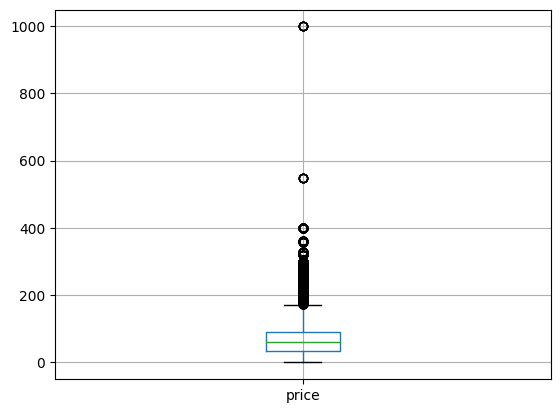

In [28]:
# um eine ausreißeranalyse durchzuführen, schauen wir uns zunächst einen boxplot an
df.boxplot(column='price')
plt.show()

**kommentar:**
- der boxplot zeigt:
  - der großteil der daten liegt im bereich 0-180
  - der median liegt etwa bei 60 (lässt sich ebenfalls über die .describe() function validieren)
  - wir haben "ausreißer" ab einem wert von etwa 180
- fachlich legen wir fest, dass wir die "ausreißer" (price > 180) mit in unsere weitere analyse einbeziehen und nicht auf die maximalen whiskers reduzieren
  - wir befinden uns in einem online-shop, wo es fachlich möglich ist, dass auch höherpreisige artikel angeboten und vertrieben werden
  - ebenfalls ist es möglich, dass artikel für einen preis von 0 als beigabe für eine bestellung vorhanden sind

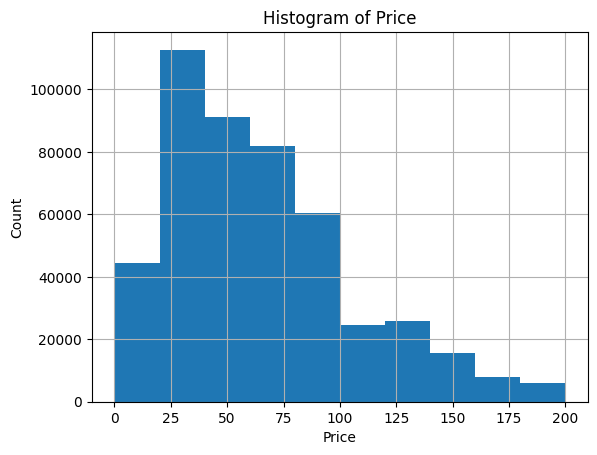

In [29]:
# für die darstellung erstellen wir einen neuen datafram, der nur aus der spalte 'price' besteht
df_price = df['price']

# im nächsten schritt (für die validierung des boxplots) entfernen wir alle datensätze mit einem price > 200
df_price.drop(df.loc[df['price']>200].index, inplace=True)

# hier erstellen wir das histogram
df_price.hist()

# hier legen wir die konfiguration des histograms fest
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175, 200])
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram of Price')

# hier lassen wir das histogram anzeigen
plt.show()

In [30]:
# um ein gefühl dafür zu bekommen, wie viele datensätze es gibt, die einen price über 180 haben, schauen wir uns dies an
df[(df['price'] >= 180)]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order
15,16,2012-04-02,2012-04-04,605,43,anthracite,1,199.90,860,Mrs,North Rhine-Westphalia,2011-03-20,0,48.665753
593,594,2012-04-03,2012-04-04,682,41,brown,54,189.90,1336,Mrs,Brandenburg,2011-08-26,0,35.695890
772,773,2012-04-01,2012-04-05,641,m,black,48,199.95,1423,Mrs,North Rhine-Westphalia,2012-04-01,0,67.476712
821,822,2012-04-03,2012-04-04,701,m,anthracite,75,199.90,1453,Mrs,Lower Saxony,2011-02-16,0,48.095890
1366,1367,2012-04-01,2012-04-04,738,11+,grey,80,200.00,1733,Mrs,Rhineland-Palatinate,2011-02-16,0,45.854795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479952,479953,2013-03-31,2013-05-01,2974,39,stained,55,189.00,86401,Mrs,Thuringia,2013-03-31,1,53.887671
479958,479959,2013-03-31,2013-04-03,2710,39,black,55,189.00,86404,Mrs,Baden-Wuerttemberg,2013-03-31,0,47.660274
480095,480096,2013-03-31,2013-04-02,2500,38,red,101,249.90,38189,Mrs,Brandenburg,2011-04-24,1,47.038356
480570,480571,2013-03-31,2013-04-03,2775,40,grey,1,199.90,86492,Mrs,Baden-Wuerttemberg,2013-03-31,0,49.873973


In [31]:
# um ein gefühl dafür zu bekommen, wie viele datensätze es gibt, die einen price = 0 haben, schauen wir uns dies an
df[(df['price'] == 0)]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order
65,66,2012-04-02,2012-04-24,239,unsized,brown,60,0.0,925,Mrs,Hesse,2011-03-16,0,53.939726
71,72,2012-04-02,2012-04-16,553,unsized,green,86,0.0,937,Mrs,Hesse,2012-03-03,0,56.594521
986,987,2012-04-03,2012-04-26,239,unsized,brown,60,0.0,1543,Mrs,Baden-Wuerttemberg,2011-11-05,0,49.671233
1250,1251,2012-04-03,NaT,157,unsized,purple,32,0.0,1687,Mrs,North Rhine-Westphalia,2012-04-02,0,47.660274
1673,1674,2012-04-04,2012-04-05,62,unsized,white,5,0.0,1848,Mrs,Baden-Wuerttemberg,2011-02-16,0,54.457534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480659,480660,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,13871,Mrs,North Rhine-Westphalia,2012-04-23,0,47.660274
480689,480690,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,51305,Mrs,Baden-Wuerttemberg,2012-09-19,0,52.090411
480705,480706,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,16759,Mrs,Brandenburg,2011-02-16,0,47.602740
480847,480848,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,34356,Mrs,North Rhine-Westphalia,2011-05-01,0,63.405479


**erledigtes to-do:**
- spalte 'price' wurde umfänglich untersucht (query und grafisch)
- es wurden fachliche entscheidungen getroffen

**kommentar:**
- jetzt kümmern wir uns um die spalten 'orderDate' und 'deliveryDate'
- auch hier wollen wir wieder eine grafische auswertung machen
- man könnte ebenfalls korrelationen untersuchen und evtl. neue features ableiten

**to-do:**
- grafische auswertung
- feature engineering

In [32]:
# feature engineering für die delivery_time, also die zeit, die eine bestellung benötigt um geliefert zu werden
df['delivery_time'] = (df['deliveryDate'] - df['orderDate'])
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order,delivery_time
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,Baden-Wuerttemberg,2011-04-25,0,47.265753,2 days
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,Baden-Wuerttemberg,2011-04-25,1,47.265753,2 days
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,Baden-Wuerttemberg,2011-04-25,1,47.265753,2 days
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,Saxony,2012-01-04,0,52.432877,NaT
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,Rhineland-Palatinate,2011-02-16,0,47.758904,-7763 days


In [33]:
df[df['deliveryDate'].isnull() & df['returnShipment'] == True]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order,delivery_time


In [34]:
# wir wollen uns die gesamten daten inkl. aller unique ausprägungen genauer anschauen
# hierfür exportieren wir die daten in einer .csv datei

# zunächst extrahieren wir das jahr aus dem deliveryDate und speichern dieses in eine neue spalte
df['delivery_year'] = df['deliveryDate'].dt.year

# um doppelte "nennungen" (wie zb xl und XL) zu vermeiden, transformieren wir alle daten in lowercase
date_counts = df['delivery_year'].value_counts()

# hier erstellen wir einen neuen pandas dataframe, der die merkmalsausprägungen (unique) inkl. anzahl enthält
result_df = pd.DataFrame({'size': date_counts.index, 'count': date_counts.values})

# das ergebnis schreiben wir anschließend in ein .csv file
result_df.to_csv('output_files/date_counts.csv', index=False)

date_counts
#df['delivery_year'].unique()

2012.0    269340
2013.0    162712
1990.0      4630
Name: delivery_year, dtype: int64

In [35]:
# neben der ausgaben von 4630 delivery_year einträgen (1990) wollen wir nun schauen, wie viele delivery_year einträge NULL sind
df[df['delivery_year'].isnull()]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order,delivery_time,delivery_year
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,Saxony,2012-01-04,0,52.432877,NaT,NaN
64,65,2012-04-02,NaT,614,35,silver,48,59.95,924,Mrs,Bavaria,2011-10-11,0,68.309589,NaT,NaN
66,67,2012-04-02,NaT,346,xl,black,5,69.90,72,Mrs,Baden-Wuerttemberg,2011-02-16,0,58.397260,NaT,NaN
67,68,2012-04-02,NaT,346,xl,mocca,5,69.90,72,Mrs,Baden-Wuerttemberg,2011-02-16,0,58.397260,NaT,NaN
68,69,2012-04-02,NaT,346,xl,purple,5,69.90,72,Mrs,Baden-Wuerttemberg,2011-02-16,0,58.397260,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481051,481052,2013-03-31,NaT,2493,42,blue,54,119.90,86558,Mrs,Lower Saxony,2013-03-31,0,47.660274,NaT,NaN
481052,481053,2013-03-31,NaT,2694,42,blue,38,99.90,86558,Mrs,Lower Saxony,2013-03-31,0,47.660274,NaT,NaN
481053,481054,2013-03-31,NaT,2663,42,blue,54,129.90,86558,Mrs,Lower Saxony,2013-03-31,0,47.660274,NaT,NaN
481054,481055,2013-03-31,NaT,2666,42,nature,54,69.90,86558,Mrs,Lower Saxony,2013-03-31,0,47.660274,NaT,NaN


**kommentar:**
- unsere idee ist es, die spalte deliveryDate zu befüllen, indem wir aus dem datensatz einen median der delivery_time berechnen und diesen auf das orderDate addieren

**to-do:**
- median berechnen
- null values mit berechnung füllen

**annahmen:**
- orderDate < deliveryDate (normaler usecase)
- orderDate > deliveryDate (daten tauschen)
- orderDate = deliveryDate (fachlich i.O., instore pickup)
- orderDate und kein deliveryDate (orderDate + median(delivery_time))

**kommentar:**
- wir treffen eine fachliche annahme für orderDate und deliveryDate:
    - wenn das deliveryDate größer dem orderDate ist, dann tauschen wir die beiden daten, damit wir die anzahl der datensätze nicht verlieren

In [36]:
# wir schauen zunächst, ob das orderDate > deliveryDate ist
# und ob die differenz zwischen deliveryDate und orderDate < als 2 wochen ist
# die fachliche annahme hierbei ist: aufgrund von feiertagen und verspätung durch die zustellung gewähren wir eine frist von 2 wochen
orderDate_greater_deliveryDate = df['orderDate'] > df['deliveryDate']
orderDate_greater_deliveryDate &= abs(df['deliveryDate'] - df['orderDate']) <= pd.Timedelta(weeks=2)

# wir müssen das orderDate zwischenspeichern, wenn der boolsche wert orderDate_greater_deliveryDate true ist
temp_orderDate = df.loc[orderDate_greater_deliveryDate, 'orderDate']

# am ende tauschen wir das orderDate und das deliveryDate
df.loc[orderDate_greater_deliveryDate, 'orderDate'] = df.loc[orderDate_greater_deliveryDate, 'deliveryDate']
df.loc[orderDate_greater_deliveryDate, 'deliveryDate'] = temp_orderDate

**kommentar:**
- an dieser stelle füllen wir nun das deliveryDate mit unserer annahme (deliveryDate + median)

In [37]:
# da wir eine große menge an ausreißern haben, berechnen wir den median der lieferzeit
# eine anwendung des mean (also mittelwerts) ist hier nicht zielführend
df = df[df['deliveryDate'].dt.year >= 2012]

median_date_diff = df['delivery_time'].median()

# wir füllen die deliveryDate NaN values
df['deliveryDate'].fillna(df['orderDate'] + median_date_diff, inplace=True)

**kommentar:**
- wir treffen eine weitere fachliche annahme für orderDate und deliveryDate:
    - wenn das deliveryDate gleich dem orderDate ist, dann behalten wir diese datensätze ohne sie zu verändern
    - wir tun dies, da wir fachlich annehmen, dass wir einen in-store pickup haben, der am selben tag passieren kann

In [38]:
# um zu validieren, bei wie vielen zeilen dies eintrifft, fragen wir auf gleichheit ab
df[(df['orderDate'] == df['deliveryDate'])]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order,delivery_time,delivery_year
1207,1208,2012-04-03,2012-04-03,402,m,blue,46,29.9,644,Mrs,North Rhine-Westphalia,2012-02-19,1,44.095890,0 days,2012.0
3752,3753,2012-04-05,2012-04-05,334,38,grey,72,99.9,1545,Mrs,North Rhine-Westphalia,2011-02-16,0,53.778082,0 days,2012.0
8664,8665,2012-04-09,2012-04-09,22,m,purple,14,39.9,4745,Mrs,Berlin,2011-09-22,1,47.660274,0 days,2012.0
8665,8666,2012-04-09,2012-04-09,22,l,purple,14,39.9,4745,Mrs,Berlin,2011-09-22,1,47.660274,0 days,2012.0
8666,8667,2012-04-09,2012-04-09,33,l,ash,5,69.9,4745,Mrs,Berlin,2011-09-22,1,47.660274,0 days,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471827,471828,2013-03-26,2013-03-26,2598,43,blue,1,149.9,48532,Mrs,North Rhine-Westphalia,2013-03-11,0,48.156164,0 days,2013.0
474965,474966,2013-03-28,2013-03-28,2439,m,blue,36,99.9,69812,Mrs,Lower Saxony,2011-05-24,1,49.610959,0 days,2013.0
477363,477364,2013-03-29,2013-03-29,3034,m,ecru,11,49.9,40699,Mrs,North Rhine-Westphalia,2012-03-03,0,47.660274,0 days,2013.0
477364,477365,2013-03-29,2013-03-29,2640,unsized,aubergine,41,19.9,40699,Mrs,North Rhine-Westphalia,2012-03-03,0,47.660274,0 days,2013.0


**kommentar:**
- wir schauen uns die spalten salutation und color an (unique ausprägungen)


In [39]:
df['salutation'].unique()

array(['Mrs', 'Mr', 'Family', 'not reported', 'Company'], dtype=object)

**kommentar:**
- hier können wir keine weiteren anpassungen vornehmen
- zur vereinheitlichung machen wir alle strings lowercase

In [40]:
df['salutation'] = df['salutation'].str.lower()

**kommentar:**
- jetzt müssen wir uns um die farben kümmern
- hierzu wollen wir einmal alle ausprägungen betrachten
- als feature wollen wir ein mapping (binning) vornehmen, indem wir die farben bestimmten "primärfarben" zuweisen

**to-do:**
- unique farben anschauen
- mapping

In [41]:
df['color'].unique()

array(['denim', 'ocher', 'curry', 'brown', 'red', 'green', 'mocca',
       'black', 'anthracite', 'olive', 'petrol', 'blue', 'grey', 'beige',
       'ecru', 'turquoise', 'magenta', 'purple', 'pink', 'khaki', 'navy',
       'habana', 'silver', 'white', 'nature', 'stained', 'orange',
       'azure', 'apricot', 'berry', 'ash', 'hibiscus', 'fuchsia', 'blau',
       'dark denim', 'mint', 'mango', 'ivory', 'yellow', 'bordeaux',
       'pallid', 'ancient', 'baltic blue', 'aquamarine', 'brwon',
       'aubergine', 'almond', 'aqua', 'dark garnet', 'avocado', 'creme',
       'champagner', 'cortina mocca', 'currant purple', 'cognac',
       'aviator', 'gold', 'ebony', 'cobalt blue', 'kanel', 'curled',
       'caramel', 'antique pink', 'dark grey', 'darkblue', 'copper coin',
       'terracotta', 'basalt', 'amethyst', 'coral', 'jade', 'opal',
       'striped', 'mahagoni', 'floral', 'dark navy', 'dark oliv', nan,
       'vanille', 'ingwer', 'iron', 'graphite', 'leopard', 'oliv',
       'bronze', 'cr

In [42]:
df['color'] = df['color'].str.lower()

In [43]:
# hier mappen wir die farben für die korrekte zuweisung auf die primärfarben
color_mapping = {
    'blue': ['denim', 'blue', 'navy', 'azure', 'baltic blue', 'dark denim', 'darkblue', 'cobalt blue', 'aquamarine', 'turquoise'],
    'brown': ['ocher', 'curry', 'brown', 'mocca', 'havana', 'khaki', 'brwon', 'kanel', 'cortina mocca', 'caramel', 'dark brown', 'copper coin', 'basalt', 'mahagoni', 'copper coin'],
    'red': ['red', 'berry', 'hibiscus', 'bordeaux', 'pallid', 'ancient', 'currant purple', 'antique pink', 'crimson'],
    'green': ['green', 'olive', 'petrol', 'khaki', 'avoacado', 'dark oliv', 'oliv', 'jade'],
    'grey': ['anthracite', 'grey', 'ash', 'dark grey', 'graphite', 'silver'],
    'beige': ['beige', 'ecru', 'nature', 'creme', 'vanille', 'ingwer', 'leopard'],
    'black': ['black', 'ebony'],
    'white': ['white', 'perlmutt'],
    'yellow': ['yellow', 'lemon', 'orange', 'gold'],
    'rose': ['pink', 'fuchsia', 'antique pink', 'magenta', 'purple', 'aubergine', 'amethyst'],
    'pattern': ['stained', 'floral', 'striped']
}

In [44]:
# unsere eigene mapping funktion um die oben erstellte mapping struktur auf das data frame anzuwenden.
def map_color_to_category(color):
   return next((category for category, color_list in color_mapping.items() if color in color_list), 'Unknown')

# anwendung unserer eigenen mapping funktion auf die color spalte welche das ergebnis der funktion in eine neue color_cat spalte schreibt
df['color_category'] = df['color'].apply(map_color_to_category)

In [45]:
# in diesem schritt droppen wir die anderen farben, da wir unser eigenes feature abgeleitet haben
df.drop(columns=['color'], inplace=True)

**kommentar:**
- jetzt schauen wir uns die spalte 'size' an

**to-do:**
- untersuchung der ausprägungen in 'size'
- entscheidung über mögliche bins treffen

In [46]:
# wir wollen uns die gesamten daten inkl. aller unique ausprägungen genauer anschauen
# hierfür exportieren wir die daten in einer .csv datei

# um doppelte "nennungen" (wie zb xl und XL) zu vermeiden, transformieren wir alle daten in lowercase
df['size_feature'] = df['size'].str.lower()
id_counts = df['size'].value_counts()

# hier erstellen wir einen neuen pandas dataframe, der die merkmalsausprägungen (unique) inkl. anzahl enthält
result_df = pd.DataFrame({'size': id_counts.index, 'count': id_counts.values})

# das ergebnis schreiben wir anschließend in ein .csv file
result_df.to_csv('output_files/size_counts.csv', index=False)

In [47]:
# alle größen, die 'l' enthalten werden zusammengefasst
mask = df['size_feature'].str.contains('l')
df.loc[mask, 'size_feature'] = 'large'

# alle größen, die 's' enthalten werden zusammengefasst
mask = df['size_feature'].str.contains('s')
df.loc[mask, 'size_feature'] = 'small'

# alle größen, die 'm' enthalten werden zusammengefasst
mask = df['size_feature'].str.contains('m')
df.loc[mask, 'size_feature'] = 'medium'

# "+" ignorieren da dies kein signifikante bedeutung bei größen hat
df['size_feature'] = df['size_feature'].str.replace('+', '')
df = df.drop(columns=['size'])

/var/folders/p0/zj7nyg753_xdmvx_vw6mbf4w0000gn/T/ipykernel_28817/924069904.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['size_feature'] = df['size_feature'].str.replace('+', '')


**kommentar:**
- jetzt wollen wir für die spalte 'state' ebenfalls ein binning vornehmen

**to-do:**
- binning für states nach regionen

In [48]:
mappings_state = {
    'north': [
        'Bremen',
        'Hamburg',
        'Mecklenburg-Western Pomerania',
        'Schleswig-Holstein',
        'Lower Saxony'
    ],
    'south': [
        'Baden-Wuerttemberg',
        'Bavaria',
    ],
    'east': [
        'Berlin',
        'Brandenburg',
        'Saxony',
        'Saxony-Anhalt',
        'Thuringia'
    ],
    'west': [
        'North Rhine-Westphalia',
        'Rhineland-Palatinate',
        'Saarland',
        'Hesse'
    ]
}

reverse_mapping = {state: location for location, states in mappings_state.items() for state in states}
df['state_loc'] = df['state'].map(reverse_mapping)

In [49]:
df.drop(columns=['state'], inplace=True)

In [50]:
df.head()

,orderItemID,orderDate,deliveryDate,itemID,manufacturerID,price,customerID,salutation,creationDate,returnShipment,age_at_order,delivery_time,delivery_year,color_category,size_feature,state_loc
0,1,2012-04-01,2012-04-03,186,25,69.90,794,mrs,2011-04-25,0,47.265753,2 days,2012.0,blue,medium,south
1,2,2012-04-01,2012-04-03,71,21,69.95,794,mrs,2011-04-25,1,47.265753,2 days,2012.0,brown,9,south
2,3,2012-04-01,2012-04-03,71,21,69.95,794,mrs,2011-04-25,1,47.265753,2 days,2012.0,brown,9,south
7,8,2012-04-02,2012-04-03,32,3,21.90,850,mrs,2011-02-16,1,64.027397,1 days,2012.0,brown,large,west
8,9,2012-04-02,2012-04-03,32,3,21.90,850,mrs,2011-02-16,1,64.027397,1 days,2012.0,red,large,west


**kommentar:**
- wir wollen versuchen ein weiteres feature hinzuzufügen, welches sich auf das alter des accounts bezieht (creationDate)

**to-do:**
- neue spalte 'account_age_at_order'
- alte spalte 'creationDate' entfernen

In [51]:
df['account_age_at_order'] = (df['orderDate'] - df['creationDate'])

In [52]:
df.drop(columns=['creationDate'], inplace=True)

In [53]:
df.head()

,orderItemID,orderDate,deliveryDate,itemID,manufacturerID,price,customerID,salutation,returnShipment,age_at_order,delivery_time,delivery_year,color_category,size_feature,state_loc,account_age_at_order
0,1,2012-04-01,2012-04-03,186,25,69.90,794,mrs,0,47.265753,2 days,2012.0,blue,medium,south,342 days
1,2,2012-04-01,2012-04-03,71,21,69.95,794,mrs,1,47.265753,2 days,2012.0,brown,9,south,342 days
2,3,2012-04-01,2012-04-03,71,21,69.95,794,mrs,1,47.265753,2 days,2012.0,brown,9,south,342 days
7,8,2012-04-02,2012-04-03,32,3,21.90,850,mrs,1,64.027397,1 days,2012.0,brown,large,west,411 days
8,9,2012-04-02,2012-04-03,32,3,21.90,850,mrs,1,64.027397,1 days,2012.0,red,large,west,411 days


___

# Datentransformation für SVM

In [54]:
from sklearn.utils import resample

In [55]:
# downsampling
df_not_returned = df[df['returnShipment'] == 0]
df_returned = df[df['returnShipment'] == 1]

In [56]:
df_not_returned_downsampled = resample(df_not_returned, replace=False, n_samples=50000, random_state=1337)
len(df_not_returned_downsampled)

50000

In [57]:
df_returned_downsampled = resample(df_returned, replace=False, n_samples=50000, random_state=1337)
len(df_returned_downsampled)

50000

In [58]:
df_downsample = pd.concat([df_not_returned_downsampled, df_returned_downsampled])
len(df_downsample)

100000

In [59]:
X = df_downsample.drop('returnShipment', axis=1).copy()
X.head()

,orderItemID,orderDate,deliveryDate,itemID,manufacturerID,price,customerID,salutation,age_at_order,delivery_time,delivery_year,color_category,size_feature,state_loc,account_age_at_order
145238,145239,2012-07-29,2012-08-01,105,45,69.9,38306,mrs,47.660274,3 days,2012.0,black,37,south,0 days
192355,192356,2012-09-04,2012-11-06,1541,20,99.9,37631,mrs,39.030137,63 days,2012.0,green,large,north,566 days
437385,437386,2013-03-09,2013-05-02,2368,119,120.0,30889,mrs,41.279452,54 days,2013.0,red,40,south,738 days
104567,104568,2012-06-26,2012-06-28,105,45,49.9,28279,mrs,43.676712,2 days,2012.0,black,41,west,14 days
15980,15981,2012-04-11,2012-04-13,222,3,49.9,7388,mrs,58.772603,2 days,2012.0,black,large,north,364 days


In [60]:
y = df_downsample['returnShipment'].copy()
y.head()

145238    0
192355    0
437385    0
104567    0
15980     0
Name: returnShipment, dtype: int64

In [61]:
X['delivery_month'] = X['deliveryDate'].dt.month
X['delivery_day'] = X['deliveryDate'].dt.day

In [62]:
X['order_year'] = X['orderDate'].dt.year
X['order_month'] = X['orderDate'].dt.month
X['order_day'] = X['orderDate'].dt.day

In [63]:
X.drop(columns=['orderDate', 'deliveryDate'], inplace=True)

In [64]:
X.head()

,orderItemID,itemID,manufacturerID,price,customerID,salutation,age_at_order,delivery_time,delivery_year,color_category,size_feature,state_loc,account_age_at_order,delivery_month,delivery_day,order_year,order_month,order_day
145238,145239,105,45,69.9,38306,mrs,47.660274,3 days,2012.0,black,37,south,0 days,8,1,2012,7,29
192355,192356,1541,20,99.9,37631,mrs,39.030137,63 days,2012.0,green,large,north,566 days,11,6,2012,9,4
437385,437386,2368,119,120.0,30889,mrs,41.279452,54 days,2013.0,red,40,south,738 days,5,2,2013,3,9
104567,104568,105,45,49.9,28279,mrs,43.676712,2 days,2012.0,black,41,west,14 days,6,28,2012,6,26
15980,15981,222,3,49.9,7388,mrs,58.772603,2 days,2012.0,black,large,north,364 days,4,13,2012,4,11


In [65]:
# für die SVM benötigen wir werte zwischen 0 und 1
# hierfür transformieren wir unsere features delivery_time und account_age_at_order vom datentyp timedelta zu float

X['delivery_time_float'] = df['delivery_time'] / pd.Timedelta(days=1)
X['account_age_at_order_float'] = df['account_age_at_order'] / pd.Timedelta(days=1)

X.drop(columns=['delivery_time', 'account_age_at_order'], inplace=True)

**kommentar:**
- wir haben nun alle werte in ein numerisches oder kategorisches format transformiert
- kategorische werte werden mit dem one-hot encoding behandelt 
- numerische werte werden mit dem minmax-scaler behandelt

**to-do:**
- one-hot encoding
- minmax-scaler

In [66]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
X.head()

,orderItemID,itemID,manufacturerID,price,customerID,salutation,age_at_order,delivery_year,color_category,size_feature,state_loc,delivery_month,delivery_day,order_year,order_month,order_day,delivery_time_float,account_age_at_order_float
145238,145239,105,45,69.9,38306,mrs,47.660274,2012.0,black,37,south,8,1,2012,7,29,3.0,0.0
192355,192356,1541,20,99.9,37631,mrs,39.030137,2012.0,green,large,north,11,6,2012,9,4,63.0,566.0
437385,437386,2368,119,120.0,30889,mrs,41.279452,2013.0,red,40,south,5,2,2013,3,9,54.0,738.0
104567,104568,105,45,49.9,28279,mrs,43.676712,2012.0,black,41,west,6,28,2012,6,26,2.0,14.0
15980,15981,222,3,49.9,7388,mrs,58.772603,2012.0,black,large,north,4,13,2012,4,11,2.0,364.0


In [68]:
# delivery
# order
minmax_columns = [
    'delivery_time_float',
    'age_at_order',
    'account_age_at_order_float',
    'price',
    'delivery_day',
    'delivery_month',
    'delivery_year',
    'order_day',
    'order_month',
    'order_year'
]

In [69]:
scaler = MinMaxScaler()
X[minmax_columns] = scaler.fit_transform(X[minmax_columns])

In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 145238 to 467061
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   orderItemID                 100000 non-null  int64  
 1   itemID                      100000 non-null  int64  
 2   manufacturerID              100000 non-null  int64  
 3   price                       100000 non-null  float64
 4   customerID                  100000 non-null  int64  
 5   salutation                  100000 non-null  object 
 6   age_at_order                100000 non-null  float64
 7   delivery_year               100000 non-null  float64
 8   color_category              100000 non-null  object 
 9   size_feature                100000 non-null  object 
 10  state_loc                   100000 non-null  object 
 11  delivery_month              100000 non-null  float64
 12  delivery_day                100000 non-null  float64
 13  order_yea

In [71]:
X.head()

,orderItemID,itemID,manufacturerID,price,customerID,salutation,age_at_order,delivery_year,color_category,size_feature,state_loc,delivery_month,delivery_day,order_year,order_month,order_day,delivery_time_float,account_age_at_order_float
145238,145239,105,45,0.06997,38306,mrs,0.367391,0.0,black,37,south,0.636364,0.000000,0.0,0.545455,0.933333,0.019608,0.000000
192355,192356,1541,20,0.10000,37631,mrs,0.278704,0.0,green,large,north,0.909091,0.166667,0.0,0.727273,0.100000,0.411765,0.731266
437385,437386,2368,119,0.12012,30889,mrs,0.301819,1.0,red,40,south,0.363636,0.033333,1.0,0.181818,0.266667,0.352941,0.953488
104567,104568,105,45,0.04995,28279,mrs,0.326454,0.0,black,41,west,0.454545,0.900000,0.0,0.454545,0.833333,0.013072,0.018088
15980,15981,222,3,0.04995,7388,mrs,0.481587,0.0,black,large,north,0.272727,0.400000,0.0,0.272727,0.333333,0.013072,0.470284


In [72]:
onehot_columns = [
    'size_feature',
    'color_category',
    'salutation',
    'state_loc'
]

In [73]:
X_encoded = pd.get_dummies(X, columns=onehot_columns)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=1337)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [76]:
clf_svm = svm.SVC(C=0.1, gamma=0.1, kernel='linear', random_state=1337)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=0.1, gamma=0.1, kernel='linear', random_state=1337)

In [77]:
import pickle

with open('models/svm_model.pkl', 'wb') as file:
    pickle.dump(clf_svm, file)

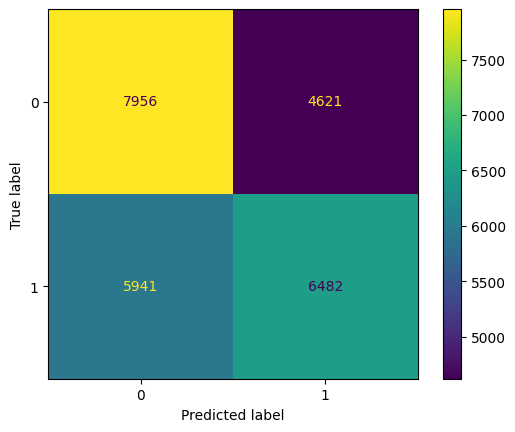

In [78]:
y_pred = clf_svm.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred, labels=clf_svm.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()
plt.show()

In [79]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Print the metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))


Accuracy: 0.58
Precision: 0.58
Recall: 0.52
F1-score: 0.55
